<h1 align="center"> Decision Trees on Donors Choose dataset</h1> 


### Importing Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

###  Importing Dataset

In [9]:
!wget --header="Host: doc-14-3k-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://drive.google.com/drive/folders/1Z9rSTNsSLyXeNI33KT9O42omfVl8AFWQ" --header="Cookie: AUTH_jpmdkrjqjlv7hqosjk23cpcg9ifqbrgq_nonce=n1kem9jsfroba" --header="Connection: keep-alive" "https://doc-14-3k-docs.googleusercontent.com/docs/securesc/8h8uvuh5ifib89027b7ihknt22nu5vgc/t7va9bgvmpo50k1actnt4qtpenckrn6g/1587475725000/00484516897554883881/05866892802988797180/1GU3LIJJ3zS1xLXXe-sdItSJHtI5txjVO?e=download&authuser=0&nonce=n1kem9jsfroba&user=05866892802988797180&hash=52na0kdlokv88v5r8oe0k3796nblteim" -c -O 'preprocessed_data.csv'

--2020-04-21 13:29:17--  https://doc-14-3k-docs.googleusercontent.com/docs/securesc/8h8uvuh5ifib89027b7ihknt22nu5vgc/t7va9bgvmpo50k1actnt4qtpenckrn6g/1587475725000/00484516897554883881/05866892802988797180/1GU3LIJJ3zS1xLXXe-sdItSJHtI5txjVO?e=download&authuser=0&nonce=n1kem9jsfroba&user=05866892802988797180&hash=52na0kdlokv88v5r8oe0k3796nblteim
Resolving doc-14-3k-docs.googleusercontent.com (doc-14-3k-docs.googleusercontent.com)... 64.233.167.132, 2a00:1450:400c:c0a::84
Connecting to doc-14-3k-docs.googleusercontent.com (doc-14-3k-docs.googleusercontent.com)|64.233.167.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘preprocessed_data.csv’

preprocessed_data.c     [        <=>         ] 118.69M  52.3MB/s    in 2.3s    

2020-04-21 13:29:20 (52.3 MB/s) - ‘preprocessed_data.csv’ saved [124454659]



In [0]:
data = pd.read_csv('preprocessed_data.csv')

In [11]:
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [0]:
negative = []
positive = []
neutral = []
compound = []

def update_sentiments(values):
    negative.append(values["neg"])    
    positive.append(values["pos"])
    neutral.append(values["neu"])
    compound.append(values["compound"])

In [13]:
from tqdm import tqdm
for essay in tqdm(data["essay"]):
    update_sentiments(sid.polarity_scores(essay))

100%|██████████| 109248/109248 [03:27<00:00, 526.52it/s]


In [0]:
data["neg"] = negative
data["pos"] = positive
data["neu"] = neutral        # adding new features to dataset based on  Sentiment Intensity Analyzer
data["compound"] = compound

In [15]:
data.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,neg,pos,neu,compound
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.205,0.783,0.9867


###   Splitting Data Into Train And Cross Validation(or test): Stratified Sampling

In [0]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=42) 

In [18]:
print("Total data points in Train Dataset =",len(y_train))
print("Total data points in Test Dataset =",len(y_test))

Total data points in Train Dataset = 73196
Total data points in Test Dataset = 36052


###  Make Data Model Ready: Encoding Eassay(text feature)

######  TFIDF Vectorizer

In [0]:
tfidfvectorizer = TfidfVectorizer(min_df=10,max_features=5000)
text_tfidf = tfidfvectorizer.fit(X_train['essay'].values) #fitting

X_train_essay_tfidf =tfidfvectorizer.transform(X_train['essay'].values) 
X_test_essay_tfidf =tfidfvectorizer.transform(X_test['essay'].values)   # transform

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 5000) (73196,)
(36052, 5000) (36052,)


####  TFIDF W2V

In [20]:
!wget --header="Host: doc-10-3k-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://drive.google.com/drive/folders/1Z9rSTNsSLyXeNI33KT9O42omfVl8AFWQ" --header="Cookie: AUTH_jpmdkrjqjlv7hqosjk23cpcg9ifqbrgq_nonce=uaih9emd25nk6" --header="Connection: keep-alive" "https://doc-10-3k-docs.googleusercontent.com/docs/securesc/8h8uvuh5ifib89027b7ihknt22nu5vgc/t30frjril2s6r6rt84jvdfcc5im19uck/1587476025000/00484516897554883881/05866892802988797180/1zJbDcbwvM2ueudqJHPpOb3Z9V2QrGd2r?e=download&authuser=0&nonce=uaih9emd25nk6&user=05866892802988797180&hash=939k2qd0inucqnck97ei14sqtt2c7if3" -c -O 'glove_vectors'

--2020-04-21 13:34:26--  https://doc-10-3k-docs.googleusercontent.com/docs/securesc/8h8uvuh5ifib89027b7ihknt22nu5vgc/t30frjril2s6r6rt84jvdfcc5im19uck/1587476025000/00484516897554883881/05866892802988797180/1zJbDcbwvM2ueudqJHPpOb3Z9V2QrGd2r?e=download&authuser=0&nonce=uaih9emd25nk6&user=05866892802988797180&hash=939k2qd0inucqnck97ei14sqtt2c7if3
Resolving doc-10-3k-docs.googleusercontent.com (doc-10-3k-docs.googleusercontent.com)... 64.233.167.132, 2a00:1450:400c:c0a::84
Connecting to doc-10-3k-docs.googleusercontent.com (doc-10-3k-docs.googleusercontent.com)|64.233.167.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘glove_vectors’

glove_vectors           [      <=>           ] 121.60M  46.6MB/s    in 2.6s    

2020-04-21 13:34:29 (46.6 MB/s) - ‘glove_vectors’ saved [127506004]



In [0]:
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'].values)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [23]:
#TFIDF W2V for train dataset
train_tfidf_w2v_essays = [] # the tfidf-w2v for each essay is stored in this list
for sentence in tqdm(X_train['essay']): 
    vector = np.zeros(300) 
    tf_idf_weight =0; 
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_essays.append(vector)
X_train_essay_tfidf_w2v= sparse.csr_matrix(train_tfidf_w2v_essays)
print("After vectorizations")
print(X_train_essay_tfidf_w2v.shape, y_train.shape)
print("="*40)

100%|██████████| 73196/73196 [02:31<00:00, 483.50it/s]


After vectorizations
(73196, 300) (73196,)


In [24]:
#TFIDF W2V for test dataset
test_tfidf_w2v_essays = [] # the tfidf-w2v for each essay is stored in this list
for sentence in tqdm(X_test['essay']): 
    vector = np.zeros(300) 
    tf_idf_weight =0;
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_essays.append(vector)
X_test_essay_tfidf_w2v= sparse.csr_matrix(test_tfidf_w2v_essays)
print("After vectorizations")
print(X_test_essay_tfidf_w2v.shape, y_test.shape)
print("="*40)

100%|██████████| 36052/36052 [01:15<00:00, 479.44it/s]


After vectorizations
(36052, 300) (36052,)


###  Make Data Model Ready: Categorical Features

#### Response Encoding

In [0]:
def fit(feature):
    X_train['class_label']=y_train # adding 'project_is_approved' column to x_train
    count = X_train[ feature ].value_counts() # getting value counts(denominator) of each category
    feature_dictionary = dict()
    for i, denominator in count.items():
        vector = []
        for j in range(2):
            compare =X_train.loc[ ( X_train['class_label'] == j ) & (X_train[feature] == i ) ]
            vector.append( len( compare)  / denominator   )
        feature_dictionary[i] = vector    # adding probability of each class label for a pariticular category of feature
    return feature_dictionary  
def transform(feature, df ):
    feature_dictionary = fit(feature)
    count = X_train[feature].value_counts()
    f=[]
    for cat in df[feature]:
        if cat in dict( count ).keys():# transform test data with trainning probabilities
            f.append( feature_dictionary[cat] )
        else:
            f.append([0.5, 0.05])
    return f

####  Encoding Categorical Features: School State

In [0]:
X_train_state_rc =np.array(transform('school_state',X_train))
X_test_state_rc =np.array(transform('school_state',X_test)) 
print("After vectorizations")
print(X_train_state_rc.shape, y_train.shape)
print(X_test_state_rc.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


#### Encoding Categorical Features: teacher_prefix

In [0]:
X_train_teacher_rc =np.array(transform('teacher_prefix',X_train))
X_test_teacher_rc = np.array(transform('teacher_prefix',X_test))
print("After vectorizations")
print(X_train_teacher_rc.shape, y_train.shape)
print(X_test_teacher_rc.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


####   Encoding Categorical Features: project_grade_category

In [0]:
X_train_grade_rc = np.array(transform('project_grade_category',X_train))
X_test_grade_rc = np.array(transform('project_grade_category',X_test))

print("After vectorizations")
print(X_train_grade_rc.shape, y_train.shape)
print(X_test_grade_rc.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


####  Encoding Categorical Features: clean_categories	

In [0]:
X_train_category_rc =np.array(transform('clean_categories',X_train))
X_test_category_rc = np.array(transform('clean_categories',X_test))

print("After vectorizations")
print(X_train_category_rc.shape, y_train.shape)
print(X_test_category_rc.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


#####  Encoding Categorical Features: 	clean_subcategories

In [0]:
X_train_subcategory_rc = np.array(transform('clean_subcategories',X_train))
X_test_subcategory_rc = np.array(transform('clean_subcategories',X_test))
print("After vectorizations")
print(X_train_subcategory_rc.shape, y_train.shape)
print(X_test_subcategory_rc.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


###  Encoding Numerical Features

#### Encoding Numerical Feature :price

In [0]:
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1)) #fitting

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))  #transform
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_norm =X_train_price_norm.reshape(-1,1)
X_test_price_norm=X_test_price_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


####  Encoding Numerical Features:teacher_number_of_previously_posted_projects	

In [0]:
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)) #fitting
X_train_submission_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))  #transform
X_test_submission_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_submission_norm =X_train_submission_norm .reshape(-1,1)
X_test_submission_norm=X_test_submission_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_submission_norm.shape, y_train.shape)
print(X_test_submission_norm.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


####  Encoding Numerical Features:neg

In [0]:
normalizer = Normalizer()
normalizer.fit(X_train['neg'].values.reshape(1,-1)) #fitting

X_train_neg_norm = normalizer.transform(X_train['neg'].values.reshape(1,-1))  #transform
X_test_neg_norm = normalizer.transform(X_test['neg'].values.reshape(1,-1))

X_train_neg_norm =X_train_neg_norm .reshape(-1,1)
X_test_neg_norm=X_test_neg_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_neg_norm.shape, y_train.shape)
print(X_test_neg_norm.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


####  Encoding Numerical Features:pos

In [0]:
normalizer = Normalizer()
normalizer.fit(X_train['pos'].values.reshape(1,-1)) #fitting

X_train_pos_norm = normalizer.transform(X_train['pos'].values.reshape(1,-1))  #transform
X_test_pos_norm = normalizer.transform(X_test['pos'].values.reshape(1,-1))

X_train_pos_norm =X_train_pos_norm .reshape(-1,1)
X_test_pos_norm=X_test_neg_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_pos_norm.shape, y_train.shape)
print(X_test_pos_norm.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


####  Encoding Numerical Features:neu

In [0]:
normalizer = Normalizer()
normalizer.fit(X_train['neu'].values.reshape(1,-1)) #fitting
X_train_neu_norm = normalizer.transform(X_train['neu'].values.reshape(1,-1))
X_test_neu_norm = normalizer.transform(X_test['neu'].values.reshape(1,-1))

X_train_neu_norm =X_train_neu_norm .reshape(-1,1)
X_test_neu_norm=X_test_neu_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_neu_norm.shape, y_train.shape)
print(X_test_neu_norm.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


####  Encoding Numerical Features:compound

In [0]:
normalizer = Normalizer()
normalizer.fit(X_train['compound'].values.reshape(1,-1)) #fitting

X_train_compound_norm = normalizer.transform(X_train['compound'].values.reshape(1,-1))  #transform
X_test_compound_norm = normalizer.transform(X_test['compound'].values.reshape(1,-1))

X_train_compound_norm =X_train_compound_norm .reshape(-1,1)
X_test_compound_norm=X_test_neu_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_compound_norm.shape, y_train.shape)
print(X_test_compound_norm.shape, y_test.shape)
print("="*40)


After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


###   Concatinating All The Features

##### SET-1

* Set 1: categorical, numerical features + preprocessed_eassay (TFIDF)

In [0]:
from scipy.sparse import hstack
X_tr_set_one = hstack((X_train_essay_tfidf, X_train_state_rc, X_train_teacher_rc, X_train_grade_rc, X_train_price_norm,X_train_category_rc,X_train_subcategory_rc,X_train_submission_norm,X_train_neg_norm ,X_train_pos_norm,X_train_neu_norm,X_train_compound_norm)).tocsr()
X_te_set_one = hstack((X_test_essay_tfidf, X_test_state_rc, X_test_teacher_rc, X_test_grade_rc, X_test_price_norm,X_test_category_rc,X_test_subcategory_rc,X_test_submission_norm,X_test_neg_norm,X_test_pos_norm,X_test_neu_norm,X_test_compound_norm)).tocsr()

In [0]:
print("SHAPE OF TRAIN AND TEST AFTER STACKING")
print(X_tr_set_one.shape)
print(X_te_set_one.shape)

SHAPE OF TRAIN AND TEST AFTER STACKING
(73196, 5016)
(36052, 5016)


#### SET-2

* Set 2: categorical, numerical features + preprocessed_eassay (TFIDF W2V)

In [0]:
from scipy.sparse import hstack
X_tr_set_two = hstack((X_train_essay_tfidf_w2v, X_train_state_rc, X_train_teacher_rc, X_train_grade_rc, X_train_price_norm,X_train_category_rc,X_train_subcategory_rc,X_train_submission_norm)).tocsr()
X_te_set_two = hstack((X_test_essay_tfidf_w2v, X_test_state_rc, X_test_teacher_rc, X_test_grade_rc, X_test_price_norm,X_test_category_rc,X_test_subcategory_rc,X_test_submission_norm)).tocsr()

In [0]:
print("SHAPE OF TRAIN AND TEST AFTER STACKING")
print(X_tr_set_two.shape)
print(X_te_set_two.shape)

SHAPE OF TRAIN AND TEST AFTER STACKING
(73196, 312)
(36052, 312)


###  GRADIENT BOOSTING CLASSIFIER USING GRID SEARCH CROSS VALIDATION (SET - 1)

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
parameters = {"max_depth":[1,2,3,4],"n_estimators":[5,10,15,20] }
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5,  scoring='roc_auc',return_train_score=True,n_jobs=-1)
clf.fit(X_tr_set_one,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [0]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

In [0]:
print('Best score: ',clf.best_score_)
print('Best Hyper parameters: ',clf.best_params_)

Best score:  0.684567328741456
Best Hyper parameters:  {'max_depth': 4, 'n_estimators': 20}


#### Plotting Hyperparameter v/s Auc

#### Roc Plot Of Train And Test Data

##### Train data

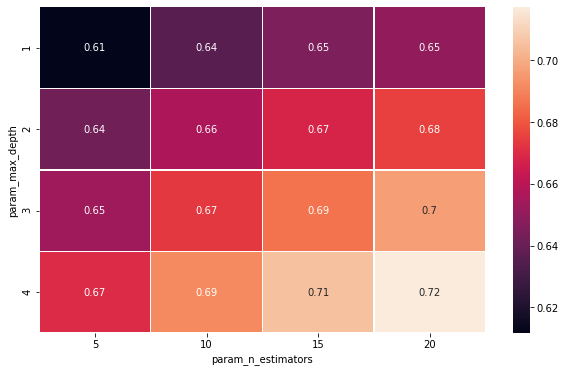

In [0]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_train_score', index='param_max_depth', columns='param_n_estimators') #https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
plt.figure(figsize=(10,6))
ax=sns.heatmap(pvt,annot=True,linewidths=.5)

##### Test data

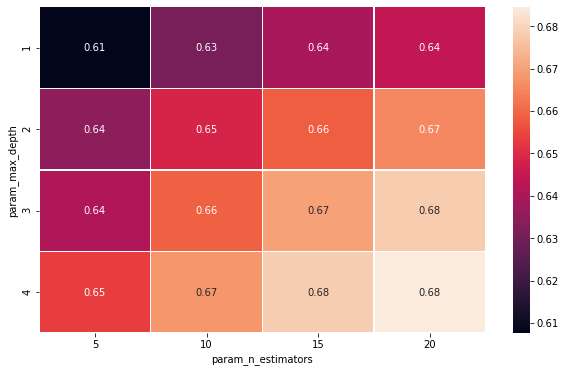

In [0]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_n_estimators') #https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
plt.figure(figsize=(10,6))
ax=sns.heatmap(pvt,annot=True,linewidths=.5)

Roc Plot Of Train And Test Data

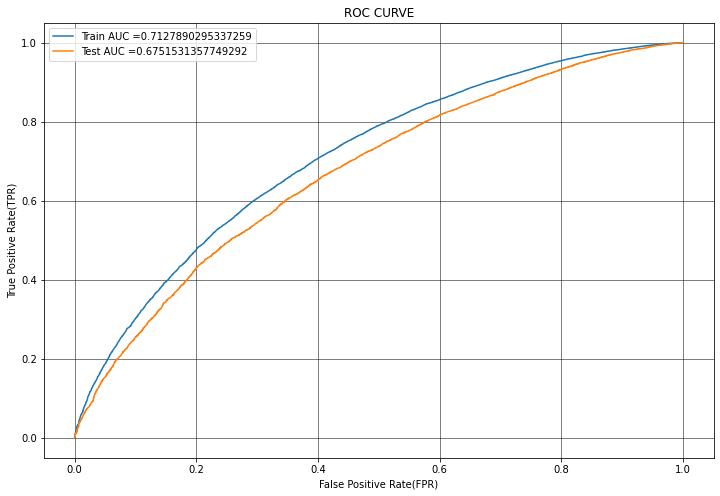

In [0]:
model_set1=GradientBoostingClassifier(max_depth = clf.best_params_["max_depth"], n_estimators= clf.best_params_["n_estimators"])
model_set1.fit(X_tr_set_one,y_train)
y_train_probs = clf.predict_proba(X_tr_set_one)[:,1] # converting train and test output into probability
y_test_probs= clf.predict_proba(X_te_set_one )[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)

plt.figure(figsize=(12,8))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC CURVE")
plt.grid(color='black',lw=0.5)

### Confusion Matrix

In [0]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

#### Train Data

the maximum value of tpr*(1-fpr) 0.4277456121087118 for threshold 0.846
CONFUSION MATRIX OF TRAIN DATA


[[ 7046  4037]
 [20322 41791]]


Text(0.5, 1.0, 'Train Data Confusion Matrix')

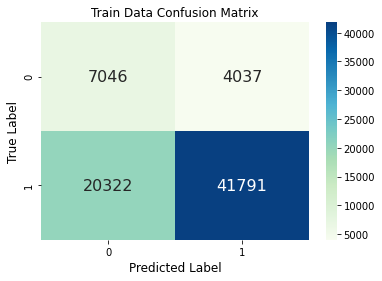

In [0]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm=metrics.confusion_matrix(y_train,predict_with_best_t(y_train_probs, best_t))  # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Train Data Confusion Matrix',size=12)

####  Test Data

the maximum value of tpr*(1-fpr) 0.39333136004500213 for threshold 0.85
CONFUSION MATRIX OF TEST DATA


[[ 3537  1922]
 [12021 18572]]


Text(0.5, 1.0, 'Test Data Confusion Matrix')

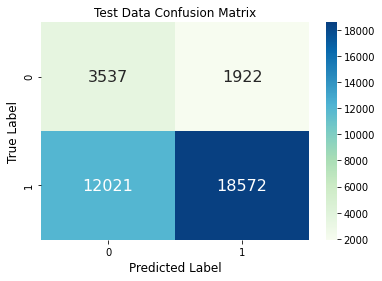

In [0]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
cm=metrics.confusion_matrix(y_test,predict_with_best_t(y_test_probs, best_t))
  
print("CONFUSION MATRIX OF TEST DATA")
print('\n')
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Test Data Confusion Matrix',size=12)

###  GRADIENT BOOSTING CLASSIFIER USING GRID SEARCH CROSS VALIDATION (SET - 2)

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
parameters = {"max_depth":[1,2,3,4],"n_estimators":[5,10,15,20] }
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5,  scoring='roc_auc',return_train_score=True,n_jobs=-1)
clf.fit(X_tr_set_two,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [0]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

In [0]:
print('Best score: ',clf.best_score_)
print('Best Hyper parameters: ',clf.best_params_)

Best score:  0.6902930550494676
Best Hyper parameters:  {'max_depth': 4, 'n_estimators': 20}


#### Plotting Hyperparameter v/s Auc

### Train Data

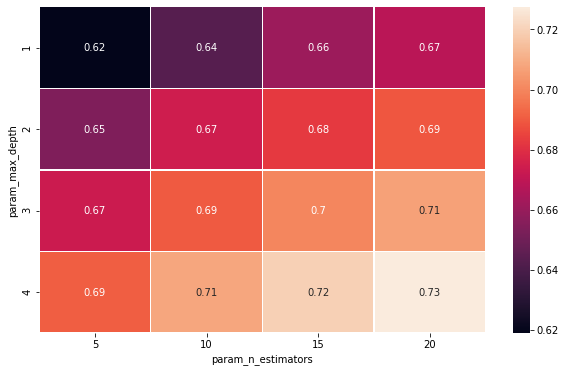

In [0]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_train_score', index='param_max_depth', columns='param_n_estimators') #https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
plt.figure(figsize=(10,6))
ax=sns.heatmap(pvt,annot=True,linewidths=.5)

### Cross Validation data

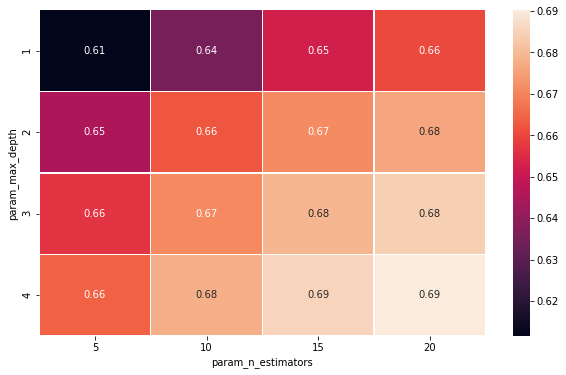

In [0]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_n_estimators') #https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
plt.figure(figsize=(10,6))
ax=sns.heatmap(pvt,annot=True,linewidths=.5)

Roc Plot Of Train And Test Data

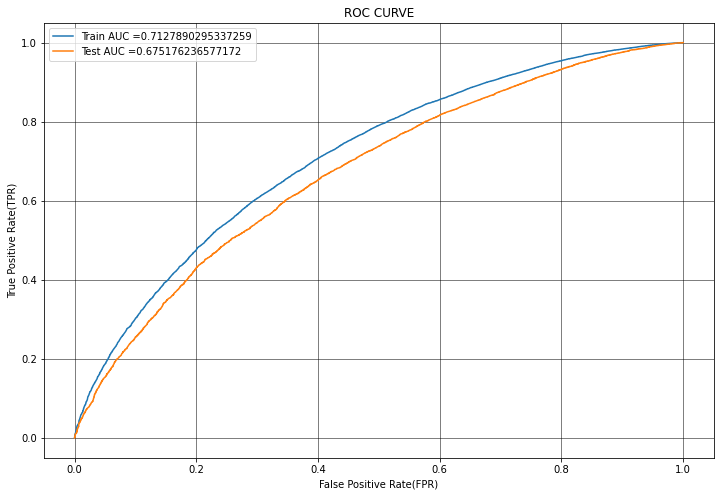

In [0]:
model_set2=GradientBoostingClassifier(max_depth = clf.best_params_["max_depth"], n_estimators= clf.best_params_["n_estimators"])
model_set2.fit(X_tr_set_one,y_train)
y_train_probs = model_set2.predict_proba(X_tr_set_one)[:,1] # converting train and test output into probability
y_test_probs= model_set2.predict_proba(X_te_set_one )[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)

plt.figure(figsize=(12,8))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC CURVE")
plt.grid(color='black',lw=0.5)

### Confusion Matrix

In [0]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

#### Train Data

the maximum value of tpr*(1-fpr) 0.4277456121087118 for threshold 0.846
CONFUSION MATRIX OF TRAIN DATA


[[ 7046  4037]
 [20322 41791]]


Text(0.5, 1.0, 'Train Data Confusion Matrix')

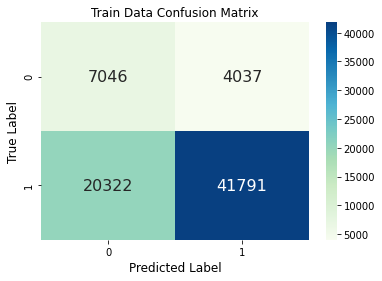

In [0]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm=metrics.confusion_matrix(y_train,predict_with_best_t(y_train_probs, best_t))  # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Train Data Confusion Matrix',size=12)



####  Test Data

the maximum value of tpr*(1-fpr) 0.3933525387742744 for threshold 0.85
CONFUSION MATRIX OF TEST DATA


[[ 3537  1922]
 [12020 18573]]


Text(0.5, 1.0, 'Test Data Confusion Matrix')

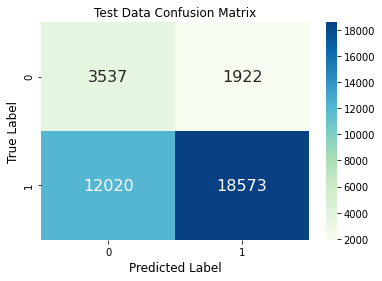

In [0]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
cm=metrics.confusion_matrix(y_test,predict_with_best_t(y_test_probs, best_t))
  
print("CONFUSION MATRIX OF TEST DATA")
print('\n')
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Test Data Confusion Matrix',size=12)

## Summary

In [26]:
from prettytable import PrettyTable
from prettytable import ALL as ALL
table=PrettyTable(hrules=ALL)
table.field_names = [ "Sl.N0","Vectorizer", "Model", "Hyper Parameter", "Test-AUC"] # # http://zetcode.com/python/prettytable/
table.add_row([1,"TFIDF", "GRADIENT BOOSTING CLASSIFIER", "max_depth =4 , n_estimators=20", 0.67515])
table.add_row([2,"TFIDF W2V", "GRADIENT BOOSTING CLASSIFIER"," max_depth =4 , n_estimators=20", 0.67517])
print(table)

+-------+------------+------------------------------+---------------------------------+----------+
| Sl.N0 | Vectorizer |            Model             |         Hyper Parameter         | Test-AUC |
+-------+------------+------------------------------+---------------------------------+----------+
|   1   |   TFIDF    | GRADIENT BOOSTING CLASSIFIER |  max_depth =4 , n_estimators=20 | 0.67515  |
+-------+------------+------------------------------+---------------------------------+----------+
|   2   | TFIDF W2V  | GRADIENT BOOSTING CLASSIFIER |  max_depth =4 , n_estimators=20 | 0.67517  |
+-------+------------+------------------------------+---------------------------------+----------+
